In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from numpy import asarray
from matplotlib import pyplot
from mtcnn import MTCNN

In [2]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
def extract_face(filename, required_size=(200, 200)):
    # load image from file
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    # use MTCNN face detector to detect faces inside the image
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

1 (200, 200, 3)
2 (200, 200, 3)
3 (200, 200, 3)
4 (200, 200, 3)
5 (200, 200, 3)
6 (200, 200, 3)
7 (200, 200, 3)
8 (200, 200, 3)
9 (200, 200, 3)
10 (200, 200, 3)
11 (200, 200, 3)


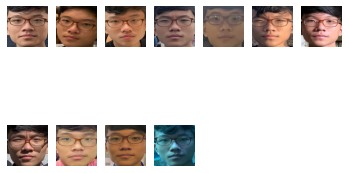

In [3]:
# specify folder to plot
def check_images():
    folder = '../Desktop/celeb/train/oswaldo/'
    i = 1
    # enumerate files
    for filename in listdir(folder):
        # path
        path = folder + filename
        # get face
        face = extract_face(path)
        print(i, face.shape)
        # plot
        pyplot.subplot(2, 7, i)
        pyplot.axis('off')
        pyplot.imshow(face)
        i += 1
    pyplot.show()

check_images()

In [4]:
def obtain_train_test_dataset(path):
    data = []
    label = []
    directorii = []
    i = 0
    for subdir, dirs, files in os.walk(path):
        if i == 0:
            directorii = dirs
        i = 1

    x = 1
    for i in directorii:
        img_path = os.path.join(path, str(i)) 
        print(img_path)
        for img in os.listdir(img_path):
            image = extract_face(img_path + '/' + img)
            images = image.astype('float32')
            images = np.array(images)


            data.append(images)
            label.append(i)

    data = np.array(data)
    label = np.array(label)

    print("success")
    return data, label

In [5]:
print("Reading train images")
x_train, y_train = obtain_train_test_dataset("../Desktop/celeb/train")
print("Reading test images")
x_test, y_test = obtain_train_test_dataset("../Desktop/celeb/val")

Reading train images
../Desktop/celeb/train\hugotan
../Desktop/celeb/train\jonathandoe
../Desktop/celeb/train\kings
../Desktop/celeb/train\morgan
../Desktop/celeb/train\oswaldo
../Desktop/celeb/train\wenling
success
Reading test images
../Desktop/celeb/val\hugotan
../Desktop/celeb/val\jonathandoe
../Desktop/celeb/val\kings
../Desktop/celeb/val\morgan
../Desktop/celeb/val\oswaldo
../Desktop/celeb/val\wenling
success


In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [7]:
# from keras.models import Sequential
# from tensorflow import keras

# def get_model():
#     model = Sequential()
#     #apply transfer learning using ResNet50
# #     model.add(keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(200, 200, 3)))
# #     model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
# #     model.add(MaxPool2D(pool_size=(2,2)))
# #     model.add(Dropout(rate=0.25))
# #     model.add(keras.layers.Flatten())

# #     model.add(Dense(5, activation="softmax"))
    
#     model.add(Conv2D(2048, (3, 3), activation='relu', input_shape=(200, 200, 3)))
#     model.add(MaxPool2D((2, 2)))
#     model.add(Conv2D(2048, (3, 3), activation='relu'))
#     model.add(MaxPool2D((2, 2)))
#     model.add(Conv2D(1024, (3, 3), activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(6))

#     model.layers[0].trainable=False
#     return model


In [12]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import GlobalAveragePooling2D

def get_model():
    model = Sequential()
    #apply transfer learning using ResNet50
    model.add(keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(200, 200, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(rate=0.25))
    model.add(keras.layers.Flatten())
    model.add(Dense(6, activation="softmax"))

    model.layers[0].trainable=False
    return model


In [13]:
def get_compiled_model():
    model = get_model()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [14]:
get_compiled_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_292 (Flatten)       (None, 2048)              0         
                                                                 
 dense_1017 (Dense)          (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_____________________________________

In [15]:
def train_model():
    model = get_compiled_model()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    
    history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test),
                       callbacks=[callback])
    [loss, acc] = model.evaluate(x_test, y_test, verbose=0)

    print("Test Set Accuracy: " + str(acc))
    return model
    
model = train_model()

Epoch 1/30
2/2 [==============================] - 9s 4s/step - loss: 2.0874 - accuracy: 0.1538 - val_loss: 1.7018 - val_accuracy: 0.2667
Epoch 2/30
2/2 [==============================] - 6s 3s/step - loss: 1.7753 - accuracy: 0.2885 - val_loss: 1.5596 - val_accuracy: 0.4000
Epoch 3/30
2/2 [==============================] - 6s 3s/step - loss: 1.6135 - accuracy: 0.4038 - val_loss: 1.3981 - val_accuracy: 0.4333
Epoch 4/30
2/2 [==============================] - 6s 3s/step - loss: 1.3764 - accuracy: 0.4904 - val_loss: 1.1949 - val_accuracy: 0.4667
Epoch 5/30
2/2 [==============================] - 6s 3s/step - loss: 1.2443 - accuracy: 0.5192 - val_loss: 1.0078 - val_accuracy: 0.7333
Epoch 6/30
2/2 [==============================] - 6s 3s/step - loss: 1.0445 - accuracy: 0.6250 - val_loss: 0.8617 - val_accuracy: 0.7667
Epoch 7/30
2/2 [==============================] - 6s 3s/step - loss: 0.9151 - accuracy: 0.6827 - val_loss: 0.7436 - val_accuracy: 0.7667
Epoch 8/30
2/2 [=========================

In [ ]:
model.save("my_modelv3.h5") #using h5 extension
print("model saved!!!")